In [28]:
import numpy as np
import pandas as pd
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

1. Data Loading:
  - A method loads in two CSV files
  - Handle cases where one file has fewer data points than the other to ensure robust data alignment. (so maybe if one file has some timestamp that another file does not have, we need to remove those)

  //1.674857e+12 timestamp is duplicate so i just drop it for now
  

In [29]:
def loadRavenAndTrakstar(trial):
  raven = pd.read_csv(f'Peg_Transfer_S01_T{trial}.csv');
  trakstar = pd.read_csv(f'Peg_Transfer_S01_T{trial}_trakStar_final.csv')
  return raven, trakstar

trial = '02'
raven, trakstar = loadRavenAndTrakstar(trial)

In [30]:
def preprocessing(raven, trakstar):
  # synchronize two files by timestamp and handle fewer data points
  trakstar.rename(columns={'Frame timestamp': 'Timestamp'}, inplace=True)
  result = pd.merge(raven, trakstar, 'inner', on=['Timestamp'], suffixes=['_raven', '_trakstar'])

  # drop missing values
  result = result.dropna()

  # check and drop duplicate data points
  duplicates_raven = raven[raven.duplicated('Timestamp', keep=False)]
  print("Duplicates in raven:")
  print(duplicates_raven)
  duplicates_trakstar = trakstar[trakstar.duplicated('Timestamp', keep=False)]
  print("\nDuplicates in trakstar:")
  print(duplicates_trakstar)
  result = result.drop_duplicates(subset='Timestamp', keep='first')

  raven  = raven[raven['Timestamp'].isin(result['Timestamp'])]
  trakstar  = trakstar[trakstar['Timestamp'].isin(result['Timestamp'])]

  return result, raven, trakstar

all_data, raven_prepared, trakstar_prepared = preprocessing(raven, trakstar)

Duplicates in raven:
Empty DataFrame
Columns: [PSML_position_x, PSML_position_y, PSML_position_z, PSMR_position_x, PSMR_position_y, PSMR_position_z, PSML_gripper_angle, PSMR_gripper_angle, Trackstar time, True frame #, Frame, Timestamp, PSML_velocity_x, PSML_velocity_y, PSML_velocity_z, PSMR_velocity_x, PSMR_velocity_y, PSMR_velocity_z]
Index: []

Duplicates in trakstar:
       PSML_position_x  PSML_position_y  PSML_position_z  PSMR_position_x  \
11609         388.9435         26.84489         -75.7907         404.5705   
11610         388.9435         26.84489         -75.7907         404.5705   

       PSMR_position_y  PSMR_position_z  PSML_gripper_angle  \
11609        -137.7405        -73.89315            0.300298   
11610        -137.7405        -73.89315            0.300298   

       PSMR_gripper_angle  Trackstar time  True frame #  Relative frame #  \
11609            0.128806    1.674854e+09         11893             11609   
11610            0.128806    1.674854e+09         

In [31]:
# trakstar.info()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11592 entries, 0 to 11591
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PSML_position_x_raven        11592 non-null  float64
 1   PSML_position_y_raven        11592 non-null  float64
 2   PSML_position_z_raven        11592 non-null  float64
 3   PSMR_position_x_raven        11592 non-null  float64
 4   PSMR_position_y_raven        11592 non-null  float64
 5   PSMR_position_z_raven        11592 non-null  float64
 6   PSML_gripper_angle_raven     11592 non-null  float64
 7   PSMR_gripper_angle_raven     11592 non-null  float64
 8   Trackstar time_raven         11592 non-null  float64
 9   True frame #_raven           11592 non-null  int64  
 10  Frame                        11592 non-null  int64  
 11  Timestamp                    11592 non-null  float64
 12  PSML_velocity_x              11592 non-null  float64
 13  PSML_velocity_y      

In [32]:
correlation_matrix = raven_prepared[['PSML_position_x', 'PSML_position_y', 'PSML_position_z',
                                  'PSMR_position_x', 'PSMR_position_y', 'PSMR_position_z']].corr()
correlation_matrix

,PSML_position_x,PSML_position_y,PSML_position_z,PSMR_position_x,PSMR_position_y,PSMR_position_z
PSML_position_x,1.000000,-0.164551,0.211662,0.687956,-0.230891,0.650631
PSML_position_y,-0.164551,1.000000,0.199106,0.025112,-0.321559,0.087213
PSML_position_z,0.211662,0.199106,1.000000,0.164265,0.165310,0.164385
PSMR_position_x,0.687956,0.025112,0.164265,1.000000,-0.321950,0.773020
PSMR_position_y,-0.230891,-0.321559,0.165310,-0.321950,1.000000,-0.669200
PSMR_position_z,0.650631,0.087213,0.164385,0.773020,-0.669200,1.000000


2. Data Visualization:
  - Stacked plots.
  - Side-by-side comparison of coordinate position in 3D.

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1608: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


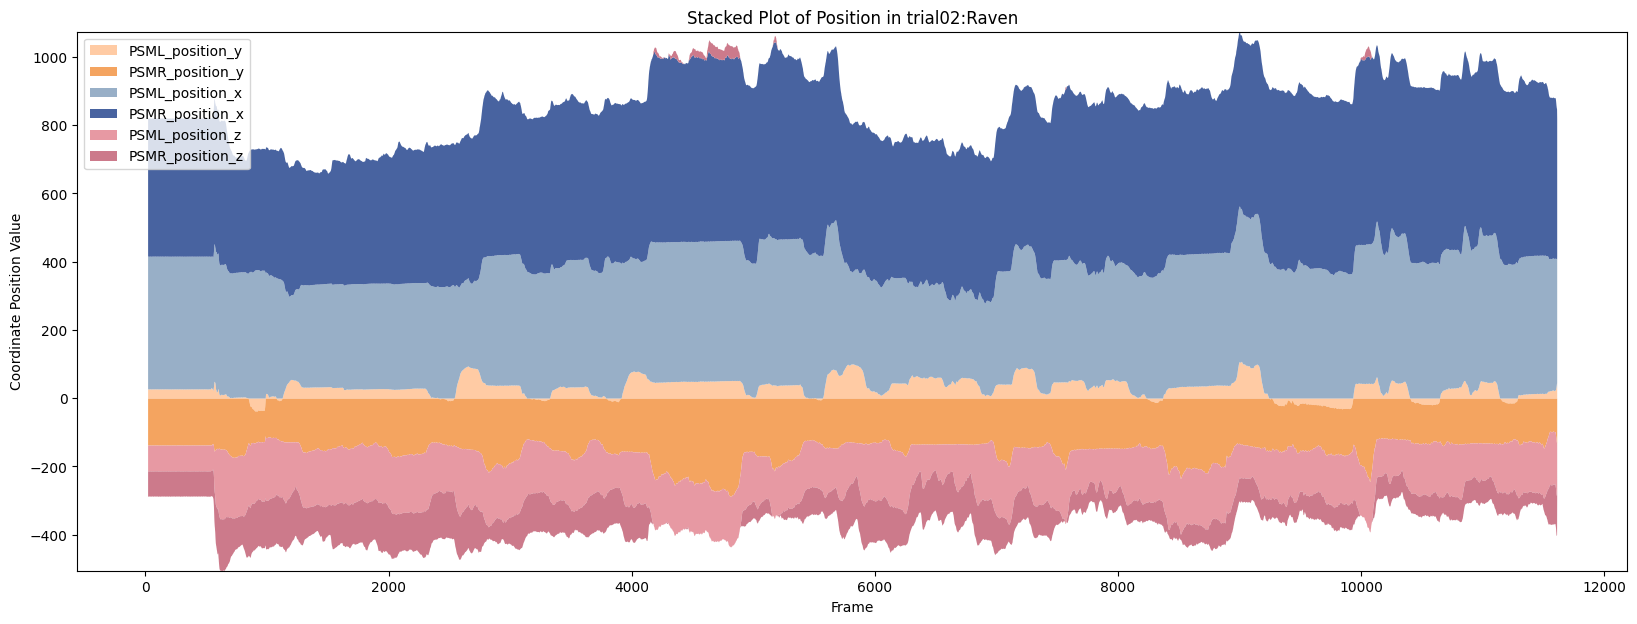

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1608: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


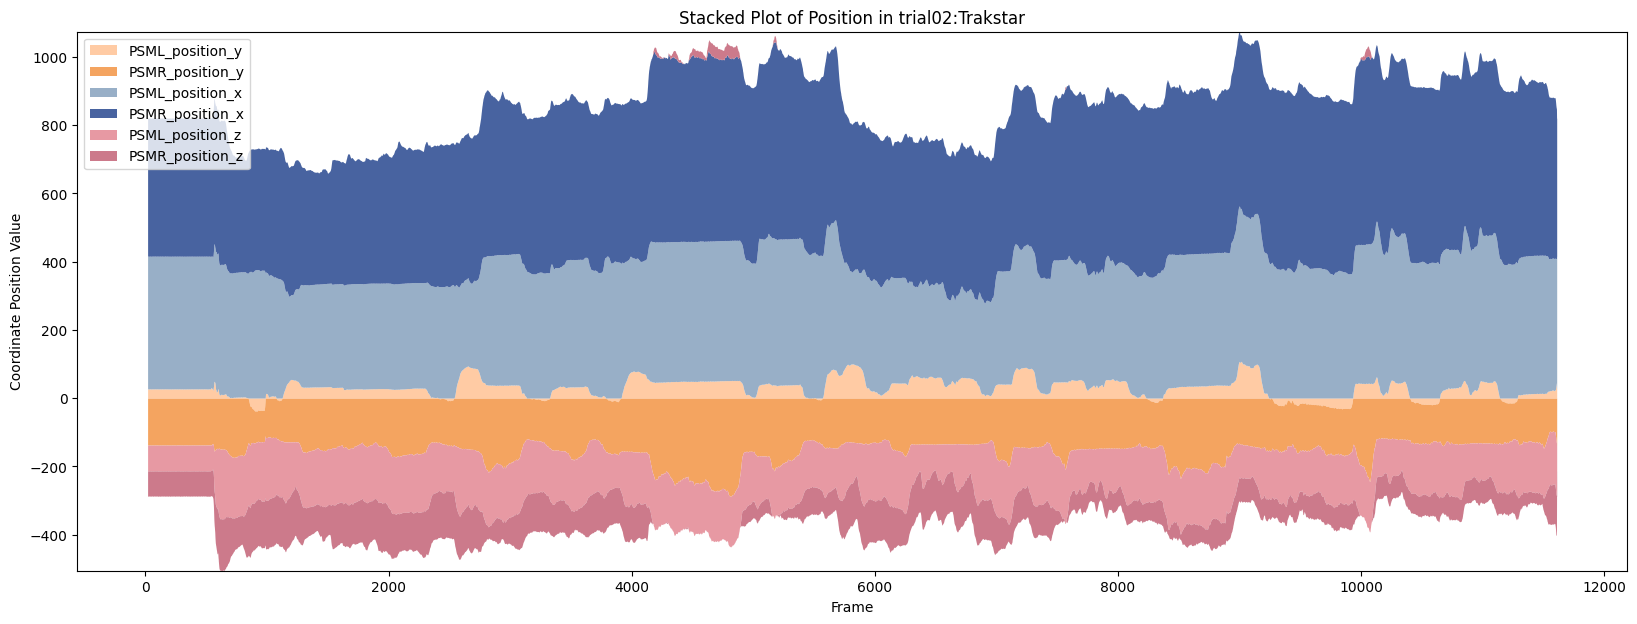

In [33]:
def makeStackedPlot(variables, trial, colors, datasetName='Raven', isPosition=True, plotDifferences=False):
  if datasetName == 'Raven':
      df = raven_prepared[['Frame'] + variables].copy()
  else:
      df = trakstar_prepared[['Relative frame #'] + variables].copy()
      df.rename(columns={'Relative frame #': 'Frame'}, inplace=True)

  if plotDifferences:
        diff_vars = []
        for i in range(0, len(variables), 2):
            new_var = f'abs_diff_{variables[i]}_{variables[i+1]}'
            df[new_var] = (df[variables[i]] - df[variables[i+1]]).abs()
            diff_vars.append(new_var)
        variables = diff_vars
        ylabel='PSML and PSMR Position Difference'
        title=f'Stacked Plot of Position Difference of Left and Right in trial{trial}:{datasetName}'
  else:
    ylabel='Coordinate Position Value'
    title=f'Stacked Plot of Position in trial{trial}:{datasetName}'

  df_neg = df.copy()
  df_neg[variables] = df_neg[variables].clip(upper=0)
  df_pos = df.copy()
  df_pos[variables] = df_pos[variables].clip(lower=0)

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,7))
  df_pos.plot.area(ax=ax, x='Frame', y=variables, stacked=True, linewidth=0., color=colors)

  df_neg.plot.area(ax=ax, x='Frame', y=variables, stacked=True, linewidth=0., color=colors)

  ax.set_ylim([df_neg[variables].sum(axis=1).min(), df_pos[variables].sum(axis=1).max()])



  handles, labels = ax.get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  ax.legend(by_label.values(), by_label.keys(), loc='upper left')
  ax.set_xlabel('Frame')
  if isPosition:
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    fig.savefig(f'{title}.png')
  else:
    ax.set_ylabel('Velocity Value')
    ax.set_title(f'Stacked Plot of Velocity in trial{trial}:{datasetName}')
    # fig.savefig(f'stacked_velocity_trial{trial}_{datasetName}.png')

  plt.show()

colors = ['#FFCBA4', '#F4A460', '#98AFC7', '#4863A0', '#E799A3', '#CC7A8B']
variables = ['PSML_position_y', 'PSMR_position_y', 'PSML_position_x', 'PSMR_position_x', 'PSML_position_z', 'PSMR_position_z']
makeStackedPlot(variables, trial, colors, "Raven")
makeStackedPlot(variables, trial, colors, "Trakstar")


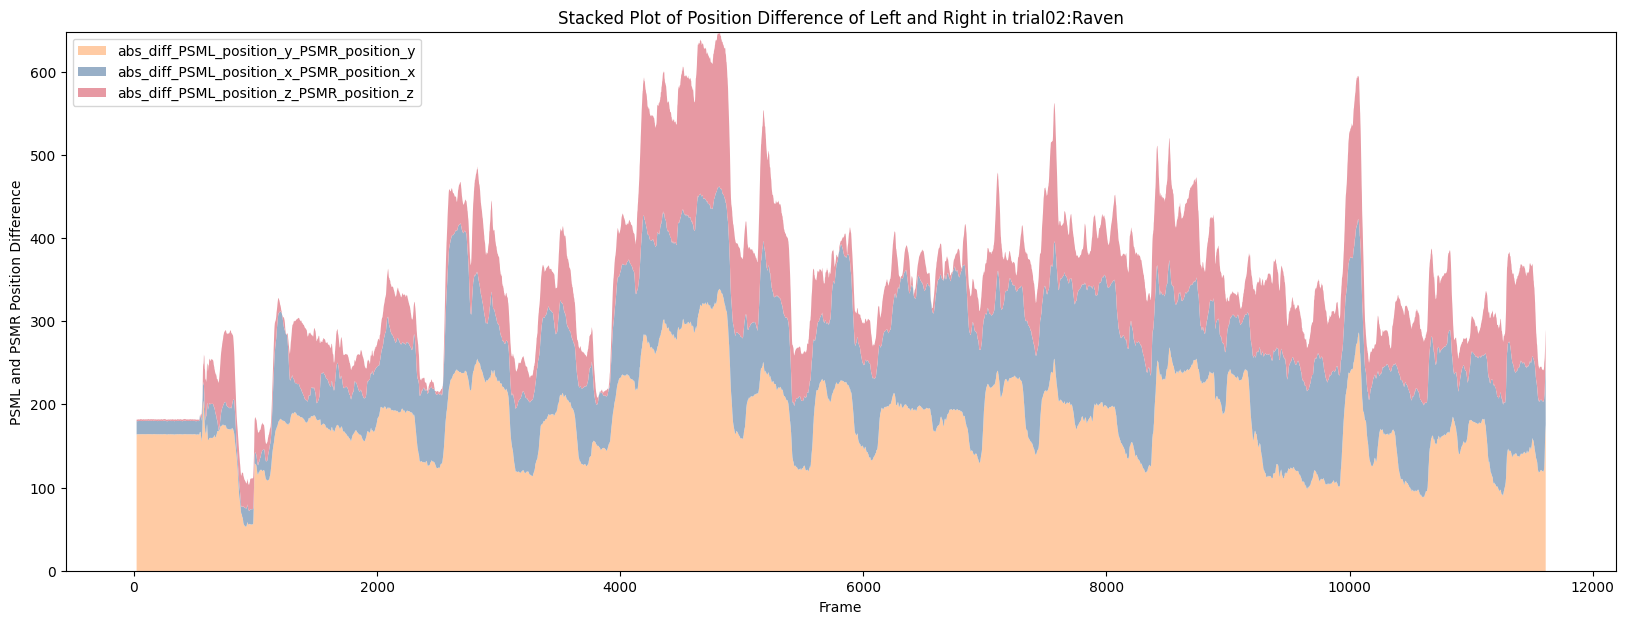

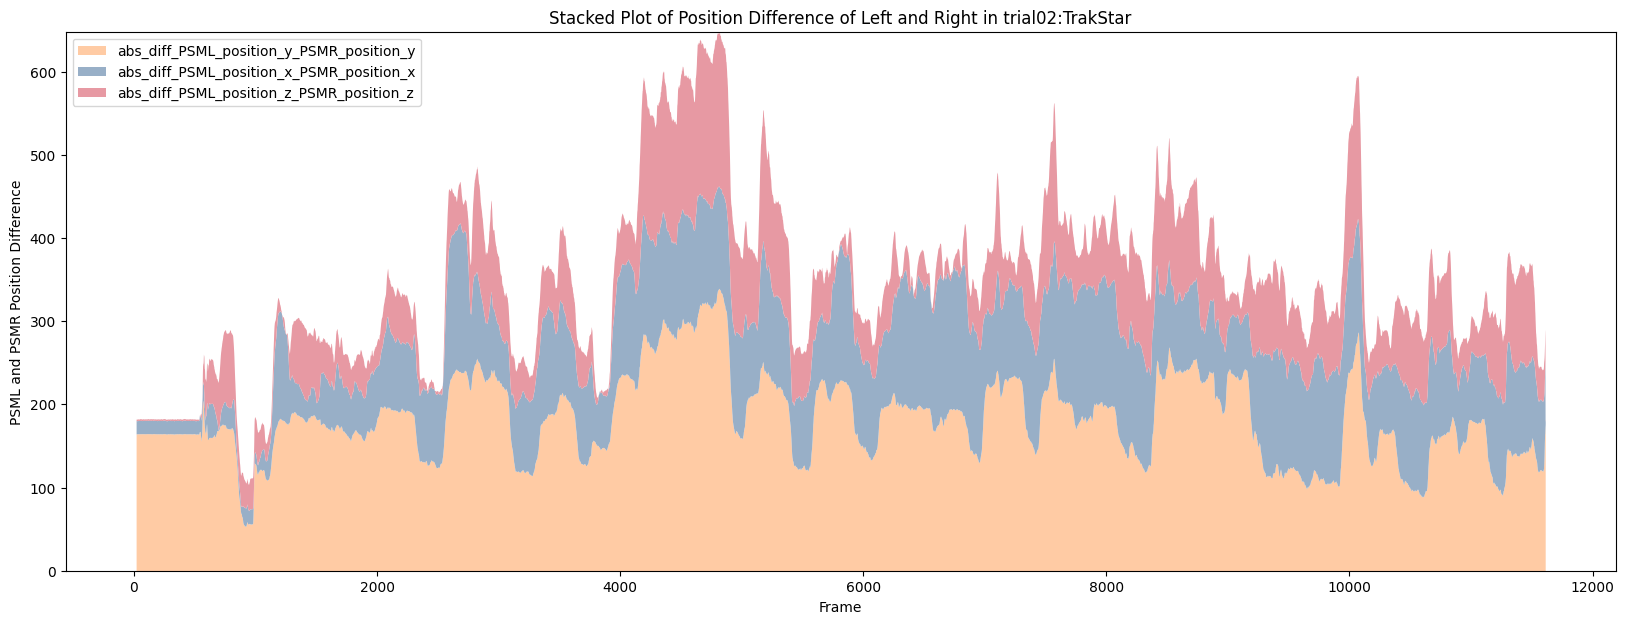

In [34]:
colors = ['#FFCBA4', '#98AFC7', '#E799A3']
variables = ['PSML_position_y', 'PSMR_position_y', 'PSML_position_x', 'PSMR_position_x', 'PSML_position_z', 'PSMR_position_z']
makeStackedPlot(variables, trial, colors, "Raven", plotDifferences=True)
makeStackedPlot(variables, trial, colors, "TrakStar", plotDifferences=True)


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1608: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


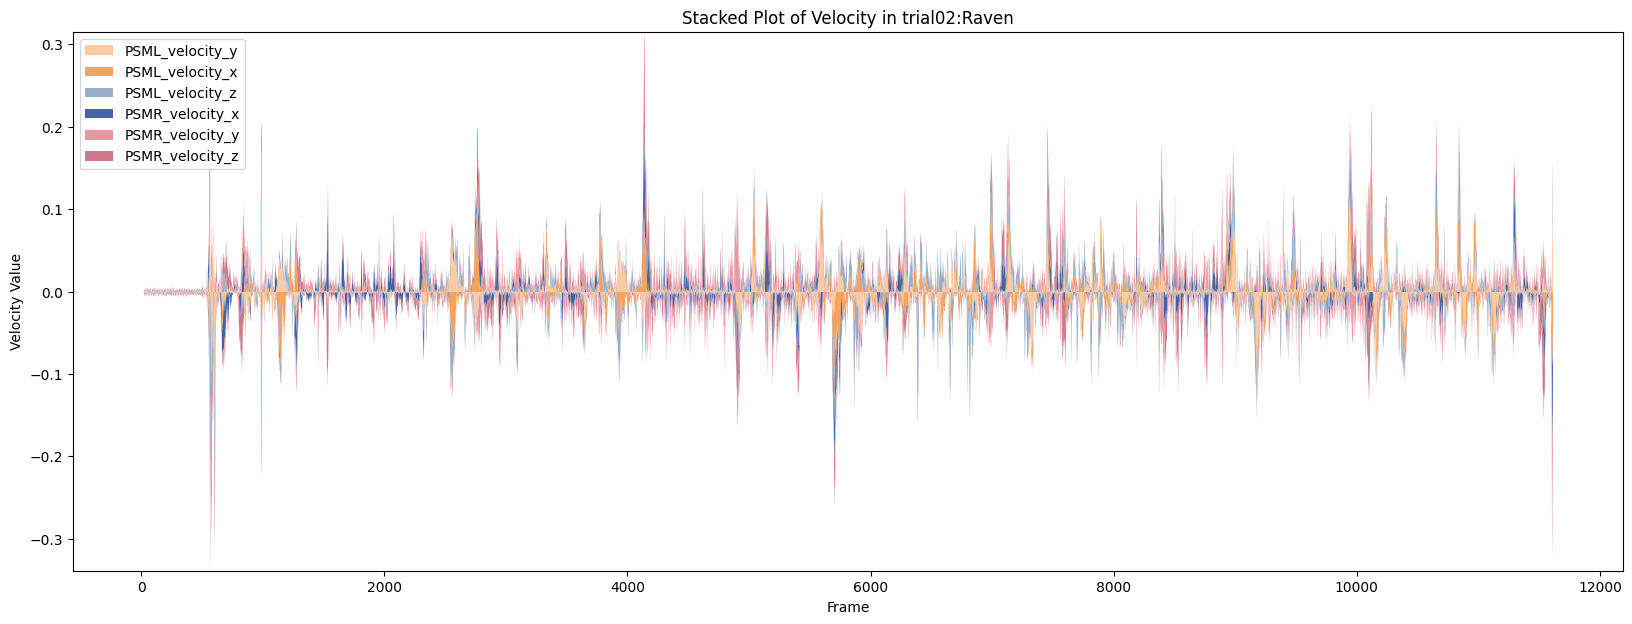

In [35]:
colors = ['#FFCBA4', '#F4A460', '#98AFC7', '#4863A0', '#E799A3', '#CC7A8B']
variables = ['PSML_velocity_y', 'PSML_velocity_x', 'PSML_velocity_z','PSMR_velocity_x', 'PSMR_velocity_y', 'PSMR_velocity_z']

makeStackedPlot(variables, trial, colors, "Raven", isPosition=False)


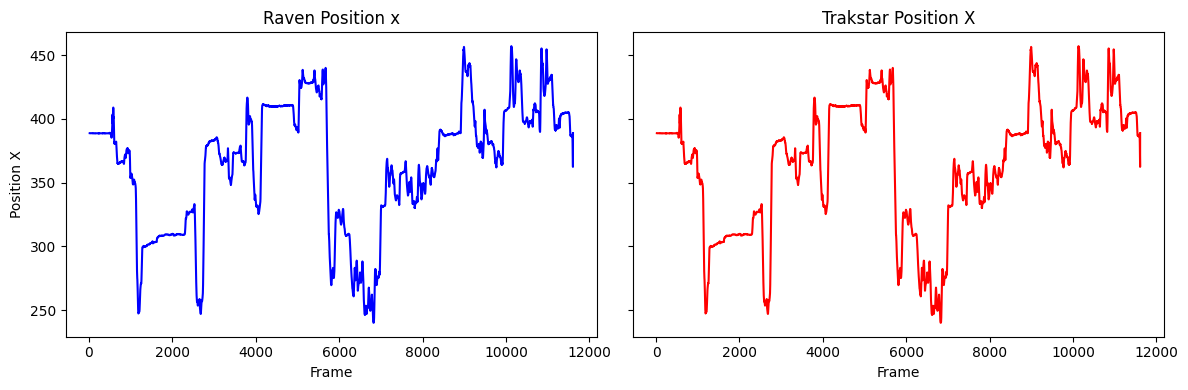

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
raven_y = all_data[['PSML_position_x_raven', 'PSML_position_y_raven', 'PSML_position_z_raven']]
trakstar_y = all_data[['PSML_position_x_trakstar', 'PSML_position_y_trakstar', 'PSML_position_z_trakstar']]

# Raven
axs[0].plot(all_data['Frame'], all_data['PSML_position_x_raven'], color='blue')
axs[0].set_title('Raven Position x')
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Position X')
# Trakstar
axs[1].plot(all_data['Frame'], all_data['PSML_position_x_trakstar'], color='red')
axs[1].set_title('Trakstar Position X')
axs[1].set_xlabel('Frame')

plt.tight_layout()
plt.show()


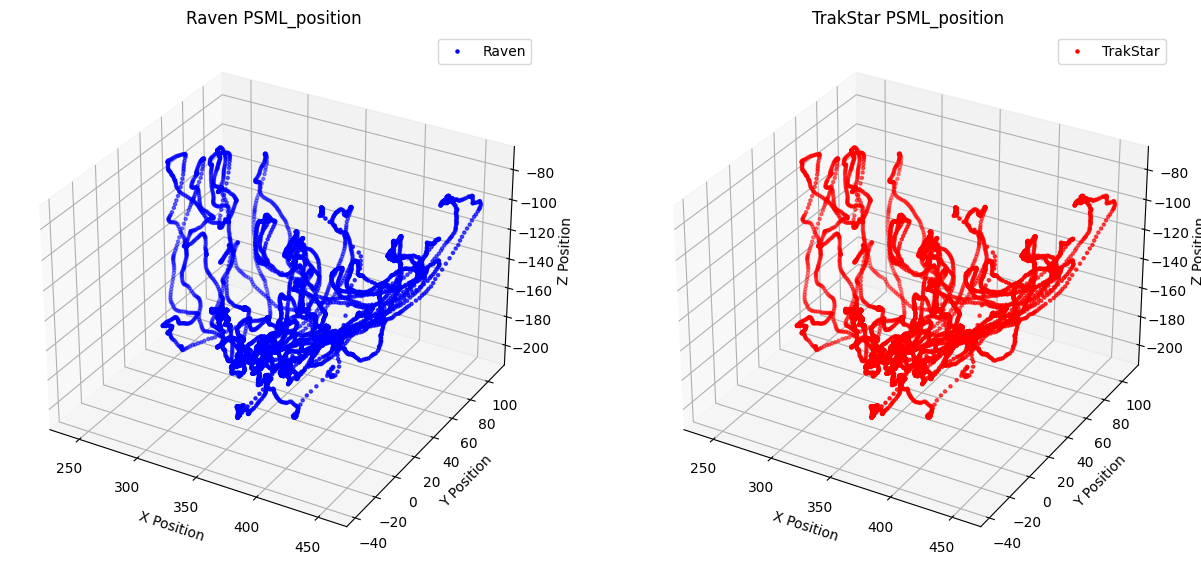

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': '3d'})
# Raven
axs[0].scatter(
    all_data['PSML_position_x_raven'],
    all_data['PSML_position_y_raven'],
    all_data['PSML_position_z_raven'],
    color='blue', marker='.', label='Raven')
axs[0].set_title('Raven PSML_position')
axs[0].set_xlabel('X Position')
axs[0].set_ylabel('Y Position')
axs[0].set_zlabel('Z Position')
axs[0].legend()

# Trakstar
axs[1].scatter(
    all_data['PSML_position_x_trakstar'],
    all_data['PSML_position_y_trakstar'],
    all_data['PSML_position_z_trakstar'],
    color='red', marker='.', label='TrakStar')
axs[1].set_title('TrakStar PSML_position')
axs[1].set_xlabel('X Position')
axs[1].set_ylabel('Y Position')
axs[1].set_zlabel('Z Position')
axs[1].legend()

plt.show()
fig.savefig(f'trial{trial}_PSML_position.png')

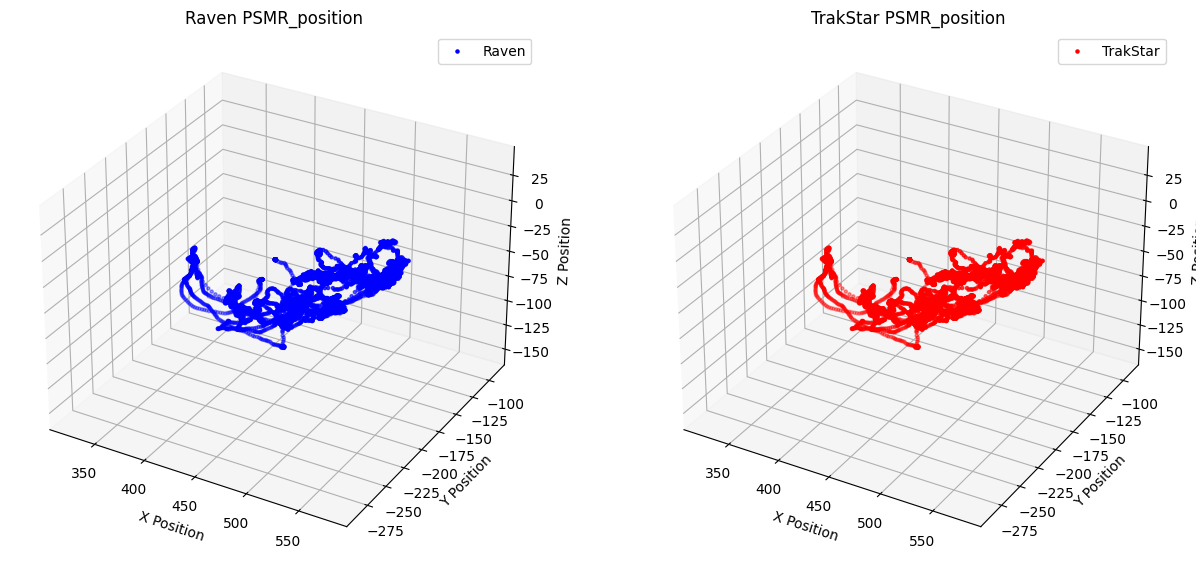

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': '3d'})
# Raven
axs[0].scatter(
    all_data['PSMR_position_x_raven'],
    all_data['PSMR_position_y_raven'],
    all_data['PSMR_position_z_raven'],
    color='blue', marker='.', label='Raven')
axs[0].set_title('Raven PSMR_position')
axs[0].set_xlabel('X Position')
axs[0].set_ylabel('Y Position')
axs[0].set_zlabel('Z Position')
axs[0].legend()
# Trakstar
axs[1].scatter(
    all_data['PSMR_position_x_trakstar'],
    all_data['PSMR_position_y_trakstar'],
    all_data['PSMR_position_z_trakstar'],
    color='red', marker='.', label='TrakStar')
axs[1].set_title('TrakStar PSMR_position')
axs[1].set_xlabel('X Position')
axs[1].set_ylabel('Y Position')
axs[1].set_zlabel('Z Position')
axs[1].legend()

plt.show()
fig.savefig(f'trial{trial}_PSMR_position.png')


3. Bonus Task:
  - select a var
  - Create an animated plot for a selected variable, synchronized with the video playing in the background.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib.backends.backend_agg import FigureCanvasAgg

video = 'Peg_Transfer_SKay_T2_27-01-2023_16-11-31_video.mp4'
cap = cv.VideoCapture(video)
fps = cap.get(cv.CAP_PROP_FPS)

# try to sync the video manually here
video_start_time = 12
video_start_frame = int(video_start_time * fps)
cap.set(cv.CAP_PROP_POS_FRAMES, video_start_frame)
data_start_frame = 200
PSML_position_x_trakstar = all_data['PSML_position_x_trakstar'][data_start_frame:data_start_frame+1000]
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('output_video.mp4', fourcc, fps, (width, 2*height))

for i in range(1000):
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    fig, ax = plt.subplots(figsize=(width/100, height/100), dpi=100)
    canvas = FigureCanvasAgg(fig)
    current_frame = data_start_frame + i
    ax.plot(range(data_start_frame, current_frame + 1), PSML_position_x_trakstar[:i + 1], color='blue')
    ax.set_xlim(data_start_frame, data_start_frame + 1000)
    ax.set_ylim(min(PSML_position_x_trakstar), max(PSML_position_x_trakstar))
    ax.set_xlabel('Frame')
    ax.set_ylabel('PSML_position_x_trakstar')
    canvas.draw()
    # converting matplotlib plot to opencv image
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    image = cv.resize(image, (width, height))
    combined_frame = np.vstack((frame, image))
    out.write(combined_frame)
    plt.close(fig)

cap.release()
out.release()
cv.destroyAllWindows()


Can't receive frame (stream end?). Exiting ...
